# Explainable AI decision trees 
Copyright 2020 Denis Rothman MIT License. See LICENSE.


## importing modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 
from sklearn.tree import DecisionTreeClassifier,plot_tree 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
import os

In [ ]:
#@title Importing data <br> Set repository to "github"(default) to read the data from GitHub <br> Set repository to "google" to read the data from Google {display-mode: "form"}
import os
from google.colab import drive

#Set repository to "github" to read the data from GitHub 
#Set repository to "google" to read the data from Google
repository="github"

if repository=="github":
  !curl -L https://raw.githubusercontent.com/PacktPublishing/Hands-On-Explainable-AI-XAI-with-Python/master/Chapter02/autopilot_data.csv --output "autopilot_data.csv"

  #Setting the path for each file
  ip="/content/autopilot_data.csv"
  print(ip)

if repository=="google":
  #Mounting the drive. If it is not mounted, a prompt will provide instructions.
  drive.mount('/content/drive')
  #Setting the path for each file
  ip='/content/drive/My Drive/XAI/Chapter02/autopilot_data.csv'
  print(ip)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92003  100 92003    0     0   129k      0 --:--:-- --:--:-- --:--:--  129k
/content/autopilot_data.csv


## reading the dataset and splitting data into features and a target value

In [ ]:
col_names = ['f1', 'f2', 'f3', 'f4','label']
# load dataset
pima = pd.read_csv(ip, header=None, names=col_names)
print(pima.head())
#split dataset in features and target variable
feature_cols = ['f1', 'f2', 'f3', 'f4']
X = pima[feature_cols] # Features
y = pima.label # Target variable
print(X)
print(y)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

     f1    f2    f3    f4  label
0  0.51  0.41  0.21  0.41      0
1  0.11  0.31  0.91  0.11      1
2  1.02  0.51  0.61  0.11      0
3  0.41  0.61  1.02  0.61      1
4  1.02  0.91  0.41  0.31      0
        f1    f2    f3    f4
0     0.51  0.41  0.21  0.41
1     0.11  0.31  0.91  0.11
2     1.02  0.51  0.61  0.11
3     0.41  0.61  1.02  0.61
4     1.02  0.91  0.41  0.31
...    ...   ...   ...   ...
3995  0.31  0.11  0.71  0.41
3996  0.21  0.71  0.71  1.02
3997  0.41  0.11  0.31  0.51
3998  0.31  0.71  0.61  1.02
3999  0.91  0.41  0.11  0.31

[4000 rows x 4 columns]
0       0
1       1
2       0
3       1
4       0
       ..
3995    1
3996    1
3997    1
3998    1
3999    0
Name: label, Length: 4000, dtype: int64


## creating the decision tree classifier

In [ ]:
# Create decision tree classifier object
# Default approach
estimator=DecisionTreeClassifier()
# Explainable AI approach
#estimator = DecisionTreeClassifier(max_depth=2,max_leaf_nodes=3,min_samples_leaf=100)

print(estimator)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


## training the model, measuring its accuracy and saving the model

In [ ]:
# Train decision tree classifier
estimator = estimator.fit(X_train,y_train)
#Predict the response for the test dataset
print("prediction")
y_pred = estimator.predict(X_test)
print(y_pred)

# Model acccuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#save model
pickle.dump(estimator, open("dt.sav", 'wb'))

prediction
[0 0 1 ... 1 1 0]
Accuracy: 1.0


## displaying the decision tree

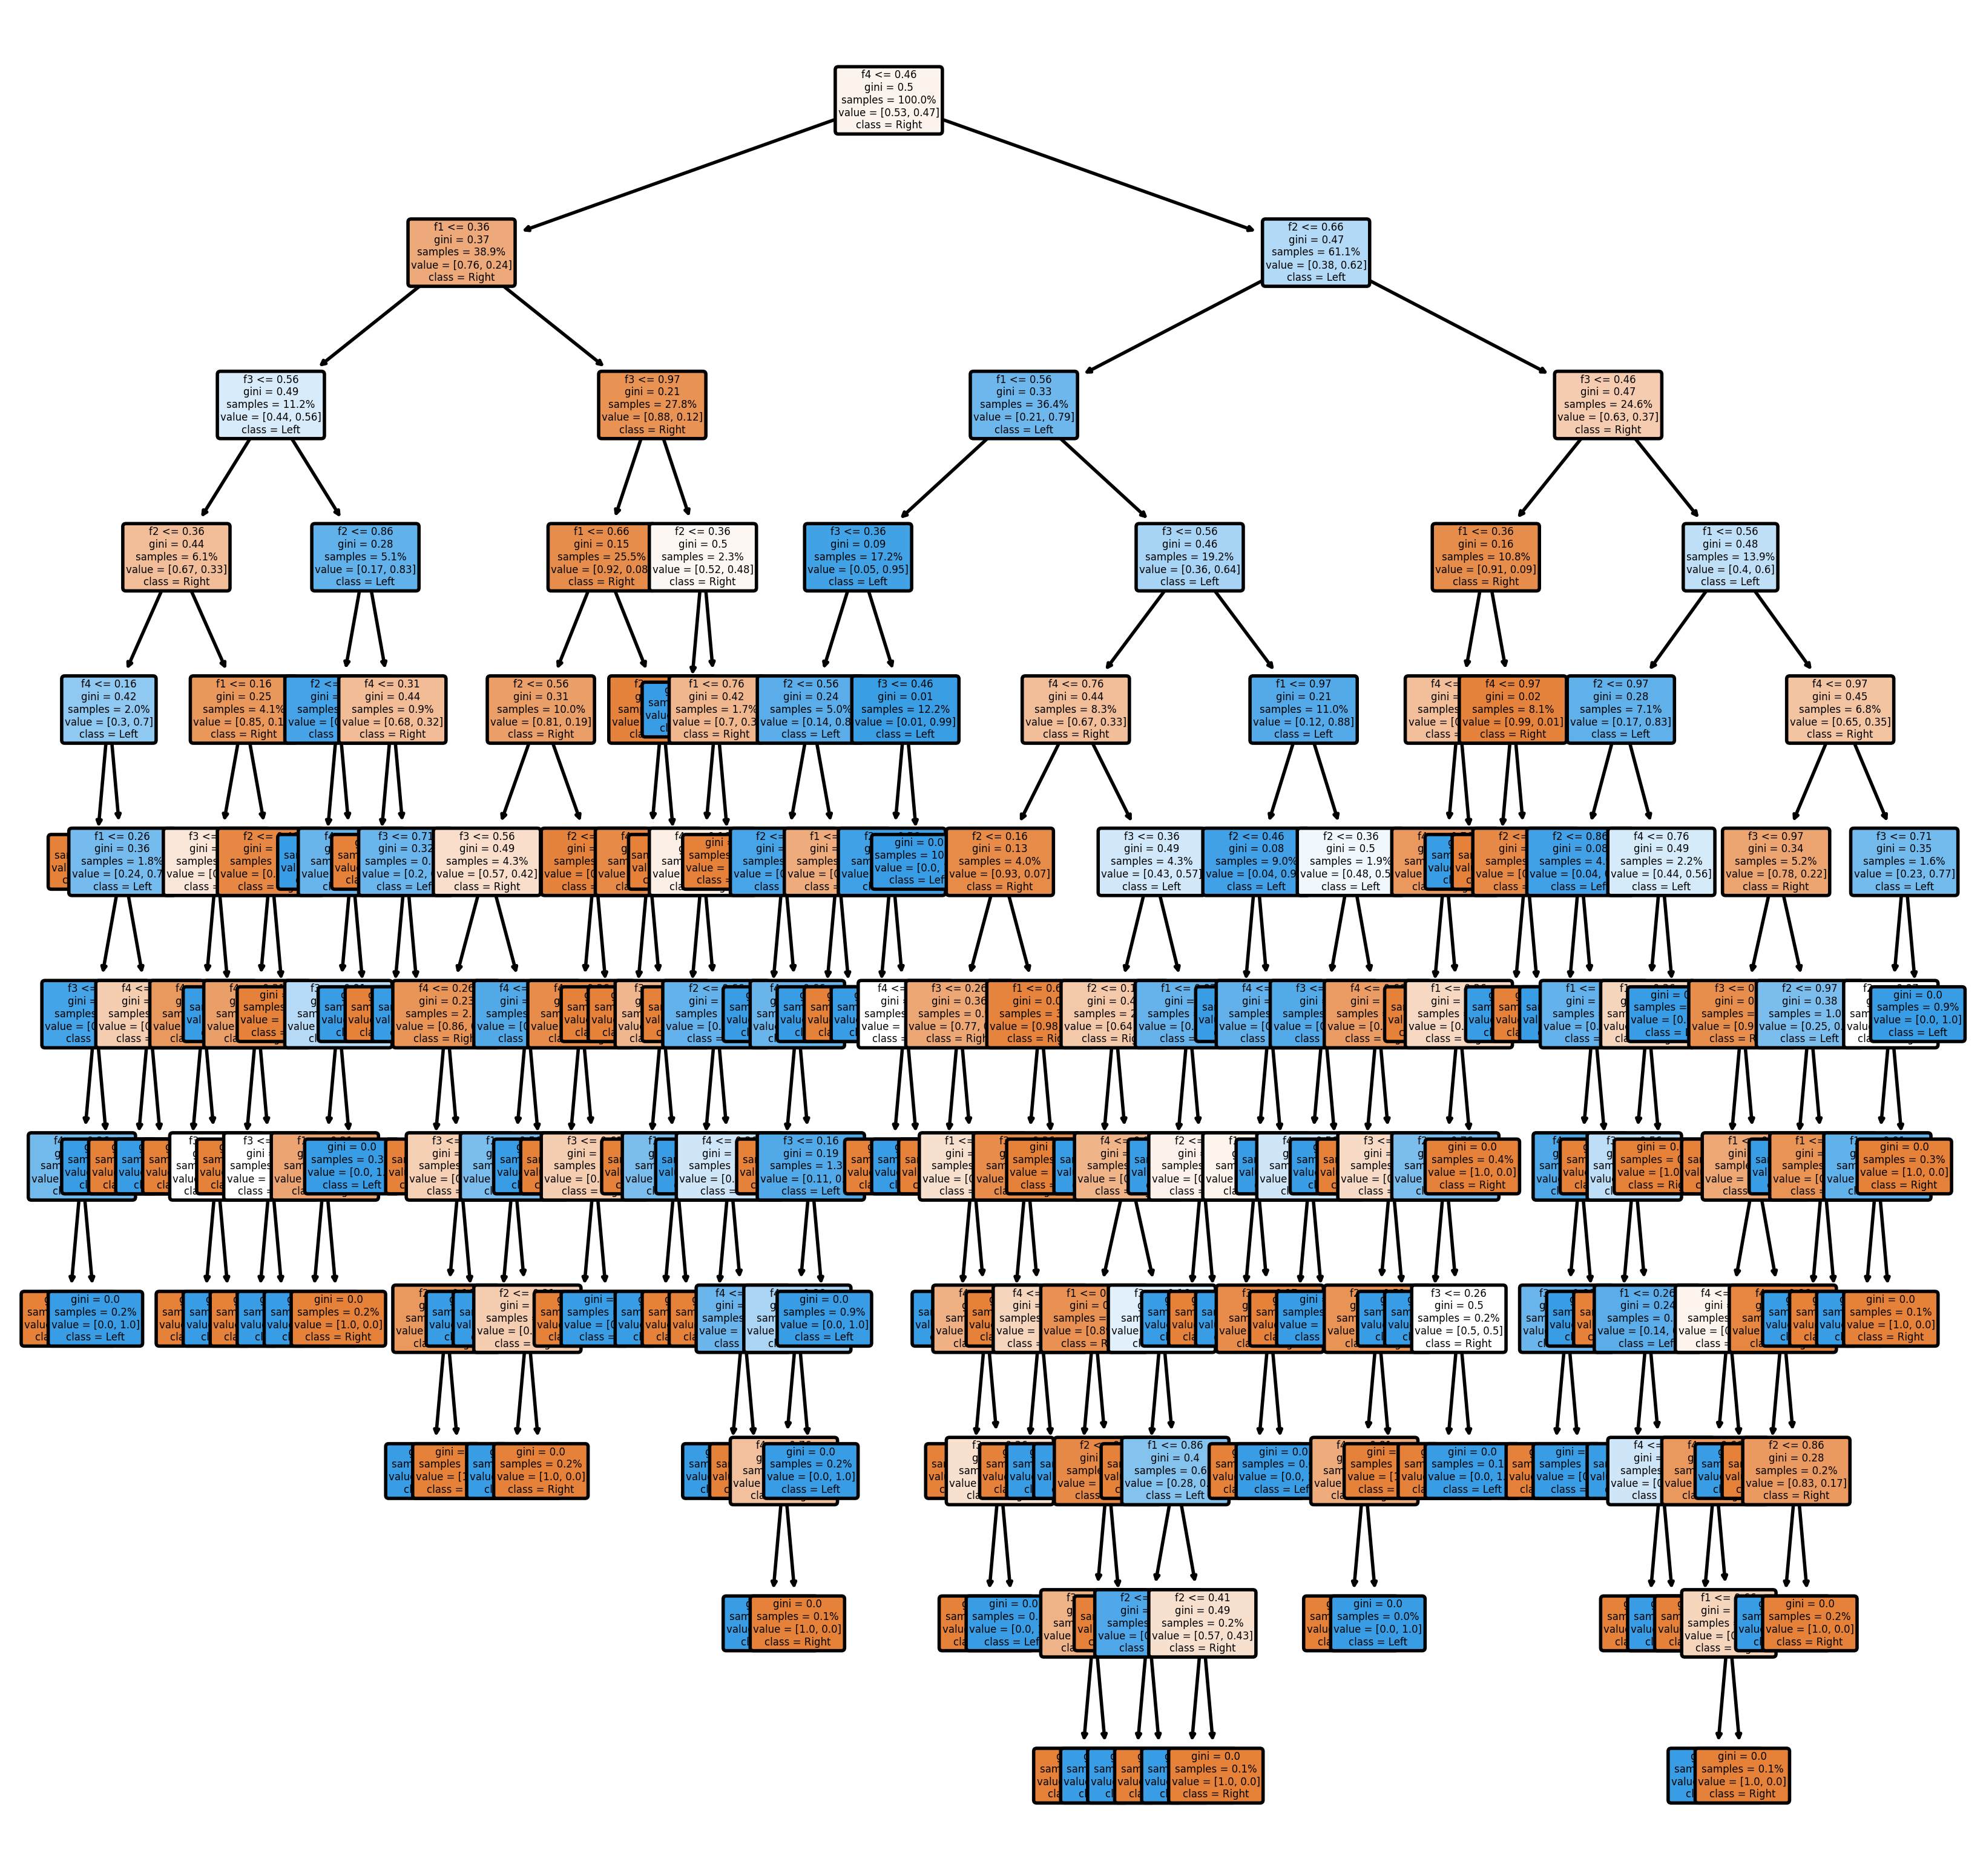

In [ ]:
from matplotlib.pyplot import figure
plt.figure(dpi=400,edgecolor="r",figsize=(10,10))
F=["f1","f2","f3","f4"]
C=["Right","Left"]
plot_tree(estimator, filled=True,feature_names=F,rounded=True,precision=2,fontsize=3,proportion=True,max_depth=None,class_names=C)
plt.savefig('dt.png')
plt.show()

## creating arrays to parse the tree structure

In [ ]:
#Creating arrays to parse the tree structure
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

## explaining the structure of a decision tree and the decision process

In [ ]:
# parsing the tree structure
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # the seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # Exploring the test mode
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))

The binary tree structure has 255 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 0.4599999934434891 else to node 92.
	node=1 test node: go to node 2 if X[:, 0] <= 0.35999999940395355 else to node 45.
		node=2 test node: go to node 3 if X[:, 2] <= 0.5600000023841858 else to node 30.
			node=3 test node: go to node 4 if X[:, 1] <= 0.35999999940395355 else to node 15.
				node=4 test node: go to node 5 if X[:, 3] <= 0.1599999964237213 else to node 6.
					node=5 leaf node.
					node=6 test node: go to node 7 if X[:, 0] <= 0.25999999791383743 else to node 12.
						node=7 test node: go to node 8 if X[:, 2] <= 0.1599999964237213 else to node 11.
							node=8 test node: go to node 9 if X[:, 3] <= 0.25999999791383743 else to node 10.
								node=9 leaf node.
								node=10 leaf node.
							node=11 leaf node.
						node=12 test node: go to node 13 if X[:, 3] <= 0.35999999940395355 else to node 14.
							node=13 leaf node.
							node=14 leaf node.

Displaying a Smaller Graph

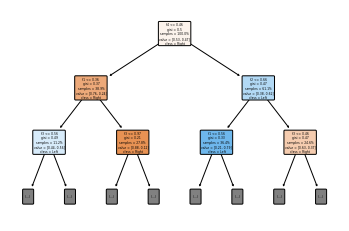

<Figure size 1200x1200 with 0 Axes>

In [ ]:
plot_tree(estimator, filled=True, feature_names=F, rounded=True,
precision=2, fontsize=3, proportion=True, max_depth=2,
class_names=C)
plt.savefig('dt.png')
plt.figure(dpi=400, edgecolor="r", figsize=(3, 3))
plt.show()

## Ethics and bias in a model

In [ ]:
#Applying the model
# Load model
dt = pickle.load(open('dt.sav', 'rb'))

t=0 #true predictions
f=0 #false predictions
for i in range(0,100):
  xf1=pima.at[i,'f1'];xf2=pima.at[i,'f2'];xf3=pima.at[i,'f3'];xf4=pima.at[i,'f4'];xclass=pima.at[i,'label']
  b1=-0.01;b2=0.02;b3=.03;b4=.02
  xf1=round(xf1*b1,2)
  xf2=round(xf2*b2,2)
  xf3=round(xf3*b3,2)
  xf4=round(xf4*b4,2)
  X_DL = [[xf1,xf2,xf3,xf4]]
  prediction =dt.predict(X_DL)
  e=False
  if(prediction==xclass):
    e=True
    t+=1
  if(prediction!=xclass):
    e=False
    f+=1
  choices=str(prediction).strip('[]')
  if float(choices)<=1:
    choice="R lane" 
  if float(choices)>=1:
    choice="L lane" 
  if float(b1+b2+b3+b4)<=0.1:
    print("Alert! Kill Switch activated!")
    break

  print (i+1,"data",X_DL," prediction:",str(prediction).strip('[]'),"class",xclass,"acc.:",e,choice)  
  
print("true:",t,"false",f,"accuracy",round(t/(t+f),3))

Alert! Kill Switch activated!
true: 1 false 0 accuracy 1.0
